In [1]:
import pandas
from keras.models import Sequential,Model
from keras import losses
from keras.layers import Dense,Activation,LSTM,Lambda
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.utils.conv_utils import convert_kernel

from random import seed
from random import choice

%matplotlib inline 
#to plot inline in jupyter notebook  
import numpy as np #for array related 
import scipy.io as spio #to load data 
import cmath #for complex operations
import matplotlib.pyplot as plt #for plotting graphs
import math # for log 
from scipy.signal import hann, welch #for spectral analysis
import keras.backend as K
import tensorflow as tf
import tensorflow.contrib.eager as tfe
from tensorflow.python.eager.context import context, EAGER_MODE, GRAPH_MODE

Using TensorFlow backend.


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
def plot_spec(spec_input,am_am = False,plot_label = None):
    
    # Spectral analyses of PA input and PA output
    Fs = 50e6
    N = np.min(np.array([1024,len(spec_input)]));
    pwin = hann(N);
    f_axis,spec_input_ps = welch(spec_input, Fs, window=pwin, nfft=N, return_onesided=False,scaling = 'spectrum',detrend=False)
    
    spec_input_ps_dB = [ 10*math.log10(abs(spec_input_ps[i])) for i in range(len(spec_input_ps)) ];

    # Plots
    f_axis = [f_axis[i]/1000000 for i in range(len(f_axis))]
    #plt.figure()
    plt.plot(f_axis,spec_input_ps_dB,label = plot_label)
    


In [3]:
mat = spio.loadmat('passthru_aligned.mat', squeeze_me=True)

op = mat['out']
ip = mat['in']
op = op/max(abs(op))

ip = ip/max(abs(ip))
print('Loaded data and scaled output')

pa_in_avg = np.mean(abs(ip))
pa_out_avg = np.mean(abs(op))
print(pa_in_avg)
print(pa_out_avg)

op = op*pa_in_avg/pa_out_avg

#ip = ip/max(abs(ip))
#op = op/(max(abs(op)))

print(max(abs(ip)))
print(max(abs(op)))



Loaded data and scaled output
0.2868036799144088
0.36599119576834394
1.0
0.783635462356703


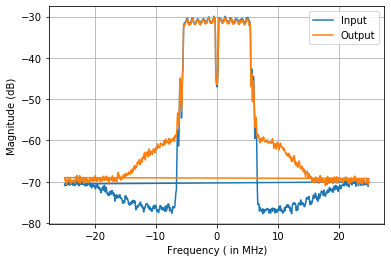

In [4]:
plt.figure()
plot_spec(ip,False,'Input')
plot_spec(op,False,'Output')
plt.legend()
plt.grid()
plt.xlabel('Frequency ( in MHz)')
plt.ylabel('Magnitude (dB)')

plt.show()


In [5]:
def Convert2Feature(input):
	output = [(np.real(i),np.imag(i)) for i in input]
	return np.array(output).reshape(-1,2)

def Convert2Complex(input):
	return np.array([t[0]+1j*t[1] for t in np.array(input)])

def Non_Linearity(input):
	input = np.array([t[0]+1j*t[1] for t in input])
	return Convert2Feature(pa(input))

def pa(input):
    return (input-0.1*input*np.exp(1j*np.pi*0.05/4)*(np.abs(input)**2)+0.005*0.1*input*np.exp(1j*np.pi*0.15/4)*(np.abs(input)**4))

def Generate_Data():
	x_train=np.random.rand(20000)*2.1-1.05
	x_train=x_train.reshape(-1,2)
	y_train=Non_Linearity(x_train)
	
	x_test=np.linspace(-1.5,1.5,200)
	x_test=x_test.reshape(-1,2)
	y_test=Non_Linearity(x_test)

	return (x_train,y_train,x_test,y_test)

def load_data(ip,op):
    train_len = 8000
    
    y_train = Convert2Feature(op[0:train_len])
    x_train = Convert2Feature(ip[0:train_len])
    x_test = Convert2Feature(ip)
    y_test = Convert2Feature(op)
    
    return (x_train,y_train,x_test,y_test)

In [6]:
x_train,y_train,x_test,y_test =  Generate_Data()
np.max(np.abs(Convert2Complex(x_train)))

1.4714988714786588

In [7]:
x_train,y_train,x_test,y_test =  load_data(ip,op)

model = Sequential()
model.add(Dense(units=2000, input_dim=2))
model.add(Activation('relu'))
model.add(Dense(units=100))
model.add(Activation('tanh'))
model.add(Dense(units=10))
model.add(Activation('linear'))
model.add(Dense(units=2))

model.compile(loss='mean_squared_error',
              optimizer='adam')

model.fit(x_train, y_train, epochs=75, batch_size=100, verbose=1)

#loss_and_metrics = model.evaluate(y_test, x_test, batch_size=100)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Epoch 1/75
8000/8000 [==============================] - 0s 56us/step - loss: 0.0040
Epoch 2/75
8000/8000 [==============================] - 0s 38us/step - loss: 0.0023
Epoch 3/75
8000/8000 [==============================] - 0s 40us/step - loss: 0.0023
Epoch 4/75
8000/8000 [==============================] - 0s 39us/step - loss: 0.0023
Epoch 5/75
8000/8000 [==============================] - 0s 55us/step - loss: 0.0023
Epoch 6/75
8000/8000 [==============================] - 0s 46us/step - loss: 0.0023
Epoch 7/75
8000/8000 [==============================] - 0s 44us/step - loss: 0.0024
Epoch 8/75
8000/8000 [==============================] - 0s 44us/step - loss: 0.0023
Epoch 9/75
8000/8000 [==============================] - 0s 38us/step - loss: 0.0023
Epoch 10/75
8000/8000 [==============================] - 0s 38us/step - loss: 0.0023
Epoch 11/75
8000/8000 [==============================] - 0s 41us/step - loss:

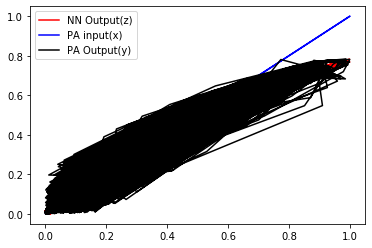

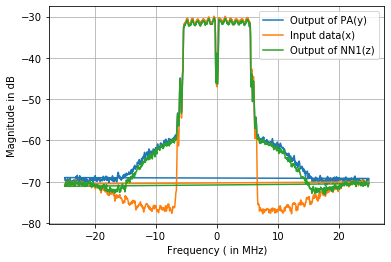

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2000)              6000      
_________________________________________________________________
activation_1 (Activation)    (None, 2000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               200100    
_________________________________________________________________
activation_2 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
_________________________________________________________________
activation_3 (Activation)    (None, 10)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                

In [8]:
x_train,y_train,x_test,y_test =  load_data(ip,op)

classes = model.predict(x_test, batch_size=100)

plt.figure()
plt.plot(np.abs(Convert2Complex(x_test)), np.abs(Convert2Complex(classes)),c='r',label = 'NN Output(z)')
plt.plot(np.abs(Convert2Complex(x_test)),np.abs(Convert2Complex(x_test)),c='b',label = 'PA input(x)')
plt.plot(np.abs(Convert2Complex(x_test)),np.abs(Convert2Complex(y_test)),c='k',label = 'PA Output(y)')
plt.legend()
plt.show()


plt.figure()
#plt.title('Magnitude spectrum for alpha = '+str(0.1)+' mse = '+str(mse))
plot_spec((Convert2Complex((y_test))),plot_label='Output of PA(y)')

plot_spec(Convert2Complex(x_test),plot_label='Input data(x)')
plot_spec((Convert2Complex(classes)),plot_label='Output of NN1(z)')
plt.xlabel('Frequency ( in MHz)')
plt.ylabel('Magnitude in dB')
plt.legend()
plt.grid(True)
plt.show()

model.summary()

In [11]:
model2 = Sequential()
model2.add(Dense(units=2000, input_dim=2))
model2.add(Activation('relu'))
model2.add(Dense(units=100))
model2.add(Activation('tanh'))
model2.add(Dense(units=10))
model2.add(Activation('linear'))
model2.add(Dense(units=2))

for layer in model.layers[:]:
    layer.trainable = False
    model2.add(layer)

    #4(dpd training) + 4(PA)
model2.compile(loss='mean_squared_error',
              optimizer='adam')

model2.fit(x_train, x_train, epochs=75, batch_size=100, verbose=1)


Epoch 1/75
8000/8000 [==============================] - 1s 86us/step - loss: 0.0018
Epoch 2/75
8000/8000 [==============================] - 1s 67us/step - loss: 2.5258e-05
Epoch 3/75
8000/8000 [==============================] - 0s 54us/step - loss: 1.7527e-05
Epoch 4/75
8000/8000 [==============================] - 0s 52us/step - loss: 1.3561e-05
Epoch 5/75
8000/8000 [==============================] - 0s 50us/step - loss: 1.0889e-05
Epoch 6/75
8000/8000 [==============================] - 0s 52us/step - loss: 9.4001e-06
Epoch 7/75
8000/8000 [==============================] - 0s 50us/step - loss: 7.3407e-06
Epoch 8/75
8000/8000 [==============================] - 0s 50us/step - loss: 5.9494e-06
Epoch 9/75
8000/8000 [==============================] - 0s 52us/step - loss: 5.3183e-06
Epoch 10/75
8000/8000 [==============================] - 0s 52us/step - loss: 4.5817e-06
Epoch 11/75
8000/8000 [==============================] - 0s 53us/step - loss: 4.1711e-06
Epoch 12/75
8000/8000 [===========

In [10]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 2000)              6000      
_________________________________________________________________
activation_4 (Activation)    (None, 2000)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               200100    
_________________________________________________________________
activation_5 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1010      
_________________________________________________________________
activation_6 (Activation)    (None, 10)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                

In [12]:
dpd = Sequential()
for layer in model2.layers[:-7]:
    dpd.add(layer)


In [16]:
dpd.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 2000)              6000      
_________________________________________________________________
activation_4 (Activation)    (None, 2000)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               200100    
_________________________________________________________________
activation_5 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1010      
_________________________________________________________________
activation_6 (Activation)    (None, 10)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                

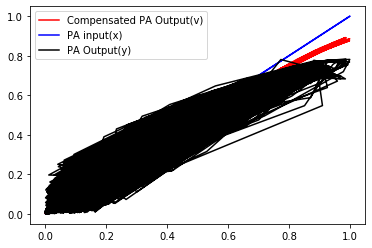

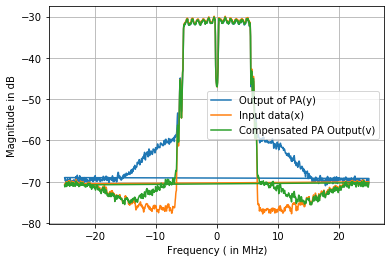

In [13]:
x_train,y_train,x_test,y_test =  load_data(ip,op)

classes = dpd.predict(x_test, batch_size=100)
classes = model.predict(classes, batch_size=100)

plt.figure()
plt.plot(np.abs(Convert2Complex(x_test)), np.abs(Convert2Complex(Non_Linearity(classes))),c='r',label = 'Compensated PA Output(v)')
plt.plot(np.abs(Convert2Complex(x_test)),np.abs(Convert2Complex(x_test)),c='b',label = 'PA input(x)')
plt.plot(np.abs(Convert2Complex(x_test)),np.abs(Convert2Complex(y_test)),c='k',label = 'PA Output(y)')
plt.legend()
plt.show()


plt.figure()
#plt.title('Magnitude spectrum for alpha = '+str(0.1)+' mse = '+str(mse))
#plot_spec(Convert2Complex(x_test),plot_label='Input to PA')
plot_spec((Convert2Complex((y_test))),plot_label='Output of PA(y)')
plot_spec(Convert2Complex(x_test),plot_label='Input data(x)')
plot_spec(pa(Convert2Complex(classes)),plot_label='Compensated PA Output(v)')
plt.xlabel('Frequency ( in MHz)')
plt.ylabel('Magnitude in dB')

plt.legend()
plt.grid(True)
plt.show()